## Data Collection from Reddit Cryptocurrency Subreddits

https://medium.com/@pasdan/how-to-scrap-reddit-using-pushshift-io-via-python-a3ebcc9b83f4

https://medium.com/swlh/how-to-scrape-large-amounts-of-reddit-data-using-pushshift-1d33bde9286



In [ ]:
#!pip install pmaw

In [1]:
import math
import json
import requests
import itertools
import numpy as np
import time
from datetime import datetime, timedelta
import praw
import pandas as pd
from pmaw import PushshiftAPI
import datetime as dt

In [2]:
# Define the name of the directory to be created. Replace with your directory location.
csv_dir = '../Data/Reddit_Comments/'

# Define directory for parquet file.
parquet_dir = '../Data/Parquet/'

In [3]:
sub_list = ['Cryptocurrency', 'Altcoin', 'Bitcoin', 'Ethereum', 'BasicAttentionToken', 'Best_of_Crypto', 'BitcoinMarkets', 
            'Blockchain', 'CryptoMarkets', 'CryptoTechnology', 'CryptoTrade', 'Algorand', 'Tezos', 'cosmosnetwork',
            'Polkadot', 'Cardano', 'Ankr']

In [17]:
# Set date intervals
before = int(dt.datetime(2021,9,8,0,0).timestamp())
after = int(dt.datetime(2021,9,7,0,0).timestamp())
end = int(dt.datetime(2021,8,8,0,0).timestamp())

days = dt.timedelta(days=1)

while before >= after:
    before = before - day
    print(before.strftime('%Y.%m.%d'))

TypeError: unsupported operand type(s) for -: 'int' and 'datetime.timedelta'

In [19]:
days = dt.timedelta(days=1)
for i in range((before - after).days - 1):
    print (before - datetime.timedelta(days=i)).strftime('%Y.%m.%d')

AttributeError: 'int' object has no attribute 'days'

In [11]:
date1 = dt.date(2021, 9, 8)
date2 = dt.date(2021, 8, 8)
day = dt.timedelta(days=1)

while date1 >= date2:
    date1 = date1 - day
    print(date1.strftime('%Y.%m.%d'))

2021.09.07
2021.09.06
2021.09.05
2021.09.04
2021.09.03
2021.09.02
2021.09.01
2021.08.31
2021.08.30
2021.08.29
2021.08.28
2021.08.27
2021.08.26
2021.08.25
2021.08.24
2021.08.23
2021.08.22
2021.08.21
2021.08.20
2021.08.19
2021.08.18
2021.08.17
2021.08.16
2021.08.15
2021.08.14
2021.08.13
2021.08.12
2021.08.11
2021.08.10
2021.08.09
2021.08.08
2021.08.07


In [ ]:
# need to convert to integer and then back to datetime

In [ ]:
# Set date intervals
before = int(dt.datetime(2021,9,8))
after = int(dt.datetime(2021,9,7))

In [ ]:
api = PushshiftAPI()
subreddit="Cryptocurrency"
limit=100000
comments = api.search_comments(subreddit=subreddit, limit=limit, before=before, after=after)
print(f'Retrieved {len(comments)} comments from Pushshift')

In [5]:
api = PushshiftAPI()
subreddit="Cryptocurrency"
limit=100000
comments = api.search_comments(subreddit=subreddit, limit=limit, before=before, after=after)
print(f'Retrieved {len(comments)} comments from Pushshift')

8906 result(s) not found in Pushshift
Total:: Success Rate: 99.55% - Requests: 1100 - Batches: 110 - Items Remaining: 896
896 result(s) not found in Pushshift
Retrieved 90198 comments from Pushshift


In [6]:
# Create dataframe
comments_df = pd.DataFrame(comments)

In [7]:
# Set pandas option to show max columns
pd.set_option('max_columns', None)

In [8]:
# preview the comments data
comments_df.head(5)

,all_awardings,archived,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_patreon_flair,author_premium,body,body_sha1,can_gild,collapsed,collapsed_because_crowd_control,collapsed_reason,collapsed_reason_code,comment_type,controversiality,created_utc,distinguished,gilded,gildings,id,is_submitter,link_id,locked,no_follow,parent_id,permalink,retrieved_utc,score,score_hidden,send_replies,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_type,top_awarded_type,total_awards_received,treatment_tags,media_metadata,author_cakeday,edited,editable
0,[],False,None,GioPowa00,None,None,[],None,None,None,text,t2_67xrcav,False,False,https://data.worldbank.org/indicator/IT.NET.US...,bd720d9debc9124323351ca0b0630a6b410ddfc5,True,False,None,None,None,None,0,1631020316,None,0,{},hbxe3ac,False,t3_pjcpcb,False,True,t1_hbxcys6,/r/CryptoCurrency/comments/pjcpcb/bitcoin_will...,1631020331,1,True,True,False,CryptoCurrency,t5_2wlj3,r/CryptoCurrency,public,None,0,[],NaN,NaN,NaN,NaN
1,[],False,None,KraBorg,,Warning-level1,"[{'e': 'text', 't': '7 - 8 years account age. ...",None,7 - 8 years account age. 400 - 800 comment karma.,dark,richtext,t2_eb791,False,True,All the money just flowing too sol draining al...,3cb7db5e029883872bf6ab8808562228e6d552b4,True,False,None,None,None,None,0,1631020316,None,0,{},hbxe39x,False,t3_pjbn1a,False,True,t3_pjbn1a,/r/CryptoCurrency/comments/pjbn1a/daily_discus...,1631020331,1,True,True,False,CryptoCurrency,t5_2wlj3,r/CryptoCurrency,public,None,0,[],NaN,NaN,NaN,NaN
2,[],False,None,lj26ft,None,Ripple,"[{'e': 'text', 't': 'Platinum | QC: XRP 531, C...",ce18a72c-21c7-11e7-a361-0ecd85cde6f8,"Platinum | QC: XRP 531, CC 250 | r/Politics 11",dark,richtext,t2_fn94h,False,True,"Short it, eventually it will be back to $15-20...",92ba09986301fb263e548616c6b3f38a4bbfffef,True,False,None,None,None,None,0,1631020314,None,0,{},hbxe35x,False,t3_pjmdrd,False,True,t3_pjmdrd,/r/CryptoCurrency/comments/pjmdrd/solana_climb...,1631020331,1,True,True,False,CryptoCurrency,t5_2wlj3,r/CryptoCurrency,public,None,0,[],NaN,NaN,NaN,NaN
3,[],False,None,ccModBot,None,noflair,[],261fc174-1507-11e4-8375-12313d224df5,,dark,text,t2_9h1vdhmt,False,False,Hello!\n\nDirect links to image or video posts...,8590661d8540fe1cfab158ae48724d0a5c3d2466,True,False,None,None,None,None,0,1631020314,moderator,0,{},hbxe353,False,t3_pjmrip,False,True,t3_pjmrip,/r/CryptoCurrency/comments/pjmrip/el_salvador_...,1631020331,1,True,True,True,CryptoCurrency,t5_2wlj3,r/CryptoCurrency,public,None,0,[],NaN,NaN,NaN,NaN
4,[],False,None,figwhistler,None,None,[],None,None,None,text,t2_h7hpw,False,False,i think you gotta start with the fundamentals....,830ef78cfc5622fbb8f6db97955073c45d6dd0ee,True,False,None,None,None,None,0,1631020312,None,0,{},hbxe30y,False,t3_pjiy0q,False,True,t3_pjiy0q,/r/CryptoCurrency/comments/pjiy0q/help_me_out_...,1631020325,1,True,True,False,CryptoCurrency,t5_2wlj3,r/CryptoCurrency,public,None,0,[],NaN,NaN,NaN,NaN


In [9]:
comments_df.columns

Index(['all_awardings', 'archived', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'body',
       'body_sha1', 'can_gild', 'collapsed', 'collapsed_because_crowd_control',
       'collapsed_reason', 'collapsed_reason_code', 'comment_type',
       'controversiality', 'created_utc', 'distinguished', 'gilded',
       'gildings', 'id', 'is_submitter', 'link_id', 'locked', 'no_follow',
       'parent_id', 'permalink', 'retrieved_utc', 'score', 'score_hidden',
       'send_replies', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_name_prefixed', 'subreddit_type', 'top_awarded_type',
       'total_awards_received', 'treatment_tags', 'media_metadata',
       'author_cakeday', 'edited', 'editable'],
      dtype='object')

In [10]:
comments_df.shape

(90198, 50)

In [20]:
cols = ['author', 'author_fullname', 'author_premium', 'body', 'collapsed', 'collapsed_because_crowd_control',
       'collapsed_reason', 'collapsed_reason_code', 'comment_type', 'controversiality', 'created_utc', 'distinguished',
       'id', 'parent_id', 'permalink']

In [61]:
df = comments_df[cols].copy()

In [62]:
df.head()

,author,author_fullname,author_premium,body,collapsed,collapsed_because_crowd_control,collapsed_reason,collapsed_reason_code,comment_type,controversiality,created_utc,distinguished,id,parent_id,permalink
0,GioPowa00,t2_67xrcav,False,https://data.worldbank.org/indicator/IT.NET.US...,False,None,None,None,None,0,1631020316,None,hbxe3ac,t1_hbxcys6,/r/CryptoCurrency/comments/pjcpcb/bitcoin_will...
1,KraBorg,t2_eb791,True,All the money just flowing too sol draining al...,False,None,None,None,None,0,1631020316,None,hbxe39x,t3_pjbn1a,/r/CryptoCurrency/comments/pjbn1a/daily_discus...
2,lj26ft,t2_fn94h,True,"Short it, eventually it will be back to $15-20...",False,None,None,None,None,0,1631020314,None,hbxe35x,t3_pjmdrd,/r/CryptoCurrency/comments/pjmdrd/solana_climb...
3,ccModBot,t2_9h1vdhmt,False,Hello!\n\nDirect links to image or video posts...,False,None,None,None,None,0,1631020314,moderator,hbxe353,t3_pjmrip,/r/CryptoCurrency/comments/pjmrip/el_salvador_...
4,figwhistler,t2_h7hpw,False,i think you gotta start with the fundamentals....,False,None,None,None,None,0,1631020312,None,hbxe30y,t3_pjiy0q,/r/CryptoCurrency/comments/pjiy0q/help_me_out_...


In [ ]:
comments_df.to_csv('../Data/Reddit_Comments/Cryptocurrency_09012021.csv', header=True, index=False, columns=list(comments_df.axes[1]))

## Sentiment Analysis with Vader

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import seaborn as sns
# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [24]:
analyser = SentimentIntensityAnalyzer()

In [25]:
# function to calculate polarity scores
pol = lambda x: analyser.polarity_scores(x)

In [63]:
clean_df = df

In [64]:
clean_df.head()

,author,author_fullname,author_premium,body,collapsed,collapsed_because_crowd_control,collapsed_reason,collapsed_reason_code,comment_type,controversiality,created_utc,distinguished,id,parent_id,permalink
0,GioPowa00,t2_67xrcav,False,https://data.worldbank.org/indicator/IT.NET.US...,False,None,None,None,None,0,1631020316,None,hbxe3ac,t1_hbxcys6,/r/CryptoCurrency/comments/pjcpcb/bitcoin_will...
1,KraBorg,t2_eb791,True,All the money just flowing too sol draining al...,False,None,None,None,None,0,1631020316,None,hbxe39x,t3_pjbn1a,/r/CryptoCurrency/comments/pjbn1a/daily_discus...
2,lj26ft,t2_fn94h,True,"Short it, eventually it will be back to $15-20...",False,None,None,None,None,0,1631020314,None,hbxe35x,t3_pjmdrd,/r/CryptoCurrency/comments/pjmdrd/solana_climb...
3,ccModBot,t2_9h1vdhmt,False,Hello!\n\nDirect links to image or video posts...,False,None,None,None,None,0,1631020314,moderator,hbxe353,t3_pjmrip,/r/CryptoCurrency/comments/pjmrip/el_salvador_...
4,figwhistler,t2_h7hpw,False,i think you gotta start with the fundamentals....,False,None,None,None,None,0,1631020312,None,hbxe30y,t3_pjiy0q,/r/CryptoCurrency/comments/pjiy0q/help_me_out_...


In [66]:
clean_df = clean_df[clean_df['body'].str.contains('Bitcoin|BTC', case=False)]
clean_df.head()

,author,author_fullname,author_premium,body,collapsed,collapsed_because_crowd_control,collapsed_reason,collapsed_reason_code,comment_type,controversiality,created_utc,distinguished,id,parent_id,permalink
11,btc_clueless,t2_aweufq0,True,The majority of Salvadorans are against the Bi...,False,None,None,None,None,0,1631020306,None,hbxe2jj,t1_hbwgarh,/r/CryptoCurrency/comments/pjcpcb/bitcoin_will...
13,AutoModerator,t2_6l4z3,True,* **[Bitcoin](https://en.wikipedia.org/wiki/Bi...,False,None,None,None,None,0,1631020305,moderator,hbxe2hi,t3_pjmsbu,/r/CryptoCurrency/comments/pjmsbu/the_day_is_h...
22,pescennius,t2_14i1sz,False,Well right now the most robust use cases are a...,False,None,None,None,None,0,1631020301,None,hbxe27m,t1_hbxcwyo,/r/CryptoCurrency/comments/pjlwiu/what_crypto_...
23,PolicyWonka,t2_4qc6d49y,False,"&gt; Under the country's Bitcoin Law, business...",False,None,None,None,None,0,1631020300,None,hbxe24p,t1_hbx3of0,/r/CryptoCurrency/comments/pjcpcb/bitcoin_will...
33,xrv01,t2_8mrk6fft,False,game assets are a different story. i get the o...,False,None,None,None,None,0,1631020292,None,hbxe1kz,t1_hbxbn10,/r/CryptoCurrency/comments/pjbn1a/daily_discus...


In [67]:
clean_df.shape

(5991, 15)

In [68]:
# creating new column 'polarity' in clean_df
clean_df['polarity'] = clean_df['body'].apply(pol)

<ipython-input-68-d9d84613ce45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['polarity'] = clean_df['body'].apply(pol)


In [69]:
# checking that worked
clean_df.head()

,author,author_fullname,author_premium,body,collapsed,collapsed_because_crowd_control,collapsed_reason,collapsed_reason_code,comment_type,controversiality,created_utc,distinguished,id,parent_id,permalink,polarity
11,btc_clueless,t2_aweufq0,True,The majority of Salvadorans are against the Bi...,False,None,None,None,None,0,1631020306,None,hbxe2jj,t1_hbwgarh,/r/CryptoCurrency/comments/pjcpcb/bitcoin_will...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
13,AutoModerator,t2_6l4z3,True,* **[Bitcoin](https://en.wikipedia.org/wiki/Bi...,False,None,None,None,None,0,1631020305,moderator,hbxe2hi,t3_pjmsbu,/r/CryptoCurrency/comments/pjmsbu/the_day_is_h...,"{'neg': 0.025, 'neu': 0.838, 'pos': 0.136, 'co..."
22,pescennius,t2_14i1sz,False,Well right now the most robust use cases are a...,False,None,None,None,None,0,1631020301,None,hbxe27m,t1_hbxcwyo,/r/CryptoCurrency/comments/pjlwiu/what_crypto_...,"{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'comp..."
23,PolicyWonka,t2_4qc6d49y,False,"&gt; Under the country's Bitcoin Law, business...",False,None,None,None,None,0,1631020300,None,hbxe24p,t1_hbx3of0,/r/CryptoCurrency/comments/pjcpcb/bitcoin_will...,"{'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'comp..."
33,xrv01,t2_8mrk6fft,False,game assets are a different story. i get the o...,False,None,None,None,None,0,1631020292,None,hbxe1kz,t1_hbxbn10,/r/CryptoCurrency/comments/pjbn1a/daily_discus...,"{'neg': 0.024, 'neu': 0.767, 'pos': 0.21, 'com..."


In [71]:
# dropping unessential columns and seperating out 'polarity' dictionary
df2 = pd.concat([clean_df.drop(['author_fullname', 'author_premium', 'collapsed', 'collapsed_because_crowd_control',
       'collapsed_reason', 'collapsed_reason_code', 'comment_type', 'controversiality', 'distinguished',
       'parent_id', 'permalink'], axis=1), clean_df['polarity'].apply(pd.Series)], axis=1)

In [72]:
df2.head()

,author,body,created_utc,id,polarity,neg,neu,pos,compound
11,btc_clueless,The majority of Salvadorans are against the Bi...,1631020306,hbxe2jj,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
13,AutoModerator,* **[Bitcoin](https://en.wikipedia.org/wiki/Bi...,1631020305,hbxe2hi,"{'neg': 0.025, 'neu': 0.838, 'pos': 0.136, 'co...",0.025,0.838,0.136,0.8385
22,pescennius,Well right now the most robust use cases are a...,1631020301,hbxe27m,"{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'comp...",0.000,0.877,0.123,0.9485
23,PolicyWonka,"&gt; Under the country's Bitcoin Law, business...",1631020300,hbxe24p,"{'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'comp...",0.000,0.902,0.098,0.3818
33,xrv01,game assets are a different story. i get the o...,1631020292,hbxe1kz,"{'neg': 0.024, 'neu': 0.767, 'pos': 0.21, 'com...",0.024,0.767,0.210,0.9846


In [49]:
# new dataframe with average polarity score for each label
scores_df = df2.groupby('created_utc')['pos'].mean().reset_index(name='avg_positive')
scores_df['avg_neutral'] = df2.groupby('created_utc')['neu'].mean()
scores_df['avg_negative'] = df2.groupby('created_utc')['neg'].mean()
scores_df['avg_compound'] = df2.groupby('created_utc')['compound'].mean()

In [75]:
# print average polarity score for each label
print('The average Positive score = ' + str(df2['pos'].mean()))
print('The average Neutral score = ' + str(df2['neu'].mean()))
print('The average Negative score = ' + str(df2['neg'].mean()))
print('The average Compound score = ' + str(df2['compound'].mean()))

The average Positive score = 0.10627023869137044
The average Neutral score = 0.8339836421298622
The average Negative score = 0.05970706059088617
The average Compound score = 0.18941121682523718


## Wordcloud

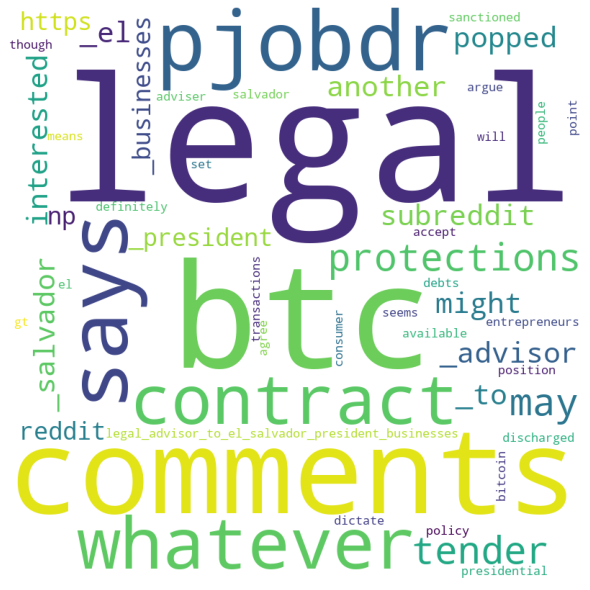

In [76]:
#Final word cloud after all the cleaning and pre-processing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in df2.body: 

   # typecaste each val to string 
   val = str(val) 

   # split the value 
   tokens = val.split() 

# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 

for words in tokens: 
    comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

## Write pandas dataframe to parquet file

In [ ]:
#!pip install pyarrow

In [ ]:
# Write Pandas Dataframe to parquet
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
# Convert DataFrame to Apache Arrow Table
table = pa.Table.from_pandas(comments_df)

In [ ]:
# Parquet write table
#pq.write_table(table, 'file_name.parquet')

In [ ]:
# Parquet with GZIP compression
pq.write_table(table, '../Data/Reddit_Comments/Cryptocurrency_09012021.parquet', compression='GZIP')

In [ ]:
# Create dataframe
p = pd.DataFrame(posts_from_reddit)
c = pd.DataFrame(comments_from_reddit)
    
# Create date string for csv file name
timestr = time.strftime("%Y%m%d")
    
# Save dataframe to csv file
p.to_csv(csv_dir + subreddit + 'posts_' + timestr + '.csv', index = False)
c.to_csv(csv_dir + subreddit + 'comments_' + timestr + '.csv', index = False)

# Save dataframe to parquet file
#p.to_parquet(parquet_dir + subreddit + '_' + timestr + '.parquet', engine='fastparquet')
#c.to_parquet(parquet_dir + subreddit + '_' + timestr + '.parquet', engine='fastparquet')